tgb - 2022/01/14 - PC experiments for AMS Annual:

1. Circle constant latitude: lat-by-lat vs concatenated, pcstable vs correlations vs SHAP, brute-force vs climate-invariant  
2. Repeat for circle of constant longitude    

# Imports

In [7]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)
tf.config.experimental.set_memory_growth(physical_devices[2], True)
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from cbrain.climate_invariant import *

import matplotlib as mpl
import numpy as np

import pickle

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

import shap
shap.initjs()

From Brei and Nando

In [8]:
def select_links(tau_min, tau_max, parents, children):
    """
    This function selects the causal links that will be tested by
    PCMCI. The links are selected such that per each variable in
    `children` all `parents` are stablished as causes, and no other
    causal relationships exist.
    
    Assumes `parents` and `children` are disjoint sets, and that all
    variables are included in the union of both sets.
    
    Parameters
    ----------
    tau_min : int
        Minimum time lag to test. Note that zero-lags are undirected.
    tau_max : int
        Maximum time lag. Must be larger or equal to tau_min.
    parents : set of int
        List of variables that will be assigned as a parent link.
        Assumed to be disjoint with children
    children : set of int
        List of variables that will be assigned a link from a parent.
        Assumed to be disjoint with parents
    Returns
    -------
    selected_links: dict
        Dictionary of selected links for Tigramite
        
    """

    parents = set(parents)
    children = set(children)

    selected_links = dict()
    # Set the default as all combinations of the selected variables
    for var in [*children, *parents]:
        if var in children:
            # Children can be caused only by parents and by themselves
            selected_links[var] = [
                (parent, -lag)
                for parent in parents
                for lag in range(tau_min, tau_max + 1)
            ]
        else:
            selected_links[var] = []

    return selected_links

Coordinates

In [9]:
pathPKL = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA'
path_folder = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/'
pathAQ_0K = path_folder + 'fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.00'
coor = xr.open_dataset(pathAQ_0K+'00-03-01-00000.nc')

In [10]:
path_folRG = '/DFS-L/DATA/pritchard/liranp/To_Tom/Output/'
path_RG0K = path_folRG + 'SST_0001Kp_Neuralnet_SPCAM_all_216/atm/hist/SST_0001Kp_Neuralnet_SPCAM_all_216.cam.h1.2013-'
path_RG0K = path_RG0K + '05-05-*.nc'

coor_RG = xr.open_mfdataset(path_RG0K,decode_cf=False)
latRG = coor_RG.lat; lonRG = coor_RG.lon; levRG = coor_RG.lev;
coor_RG.close();

In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).


In [5]:
np.argmin(np.abs(coor_RG.lev-500))

<xarray.DataArray 'lev' ()>
array(18)

In [6]:
coor_RG.lev[18].values

array(524.68717471)

Plotting parameters

In [5]:
fz = 15 # Here we define the fontsize 
lw = 2 # the linewidth
siz = 75 # and the scattered dots' size

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

# Prepare data

## Reorganize raw dataset to make it a time serie

In [6]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [3]:
path_train = path_data + '2022_01_10_TRAIN_For_Nando_t-dt.nc' 
path_valid = path_data + '2022_01_10_VALID_For_Nando_t-dt.nc'
path_norm = path_data + '2022_01_10_Norm_Outputs_t-dt.nc'

In [4]:
train_data_raw = xr.open_dataset(path_train)

In [41]:
raw_var_name = train_data_raw['var_names'].values

In [18]:
Nlat = 64
Nlon = 128
NT = int(train_data_raw['vars'].shape[0]/(Nlat*Nlon))
Ninp0 = 94 # without tendencies at t-dt
Noup = 65
Ninp = Ninp0+Noup
Nvars = Ninp+Noup

In [6]:
raw_vars = train_data_raw['vars'].values

In [17]:
raw_vars = np.reshape(raw_vars,(NT,Nlat,Nlon,Nvars))

In [39]:
raw_vars_time = DT*np.arange(0,NT)/(24*3600)

In [117]:
N_toexclude = 2 # Exclude upper atmospheric PHQ as inputs because zero

In [118]:
input0_idx = np.arange(0,Ninp0)
inputs_idx = np.concatenate((input0_idx,np.arange(Ninp0+Noup+N_toexclude,Nvars)))
output_idx = np.arange(Ninp0+N_toexclude,Ninp0+Noup)

In [104]:
iNST = 59
NST = np.mean(raw_vars[:,:,:,iNST],axis=0)

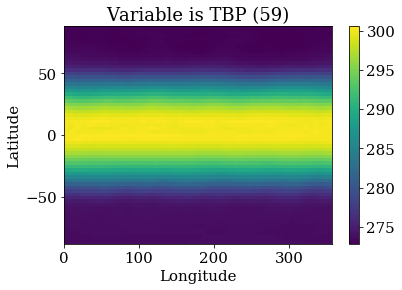

In [26]:
plt.pcolormesh(coor.lon,coor.lat,NST)
plt.colorbar()
plt.title('Variable is '+(train_data_raw['var_names'].values)[iNST]+' ('+str(iNST)+')');
plt.xlabel('Longitude');
plt.ylabel('Latitude');

## Reorganize PRECTt-dt data to make it into a time series

In [7]:
path_train = path_data + '2022_01_17_RG_TRAIN_M4K_PRECTt-dt.nc'
path_valid = path_data + '2022_01_17_RG_VALID_M4K_PRECTt-dt.nc'
path_norm = path_data + '2022_01_13_NORM_For_Nando_CI_t-dt.nc'

In [8]:
train_data_raw = xr.open_dataset(path_train)

In [11]:
train_data_raw

<xarray.Dataset>
Dimensions:    (sample: 143161344, var_names: 66)
Coordinates:
  * var_names  (var_names) object 'QBP' 'QBP' 'QBP' ... 'PRECTt-dt' 'PRECT'
    time       (sample) int64 ...
    lat        (sample) float64 ...
    lon        (sample) float64 ...
Dimensions without coordinates: sample
Data variables:
    vars       (sample, var_names) float32 ...

In [9]:
raw_var_name = train_data_raw['var_names'].values

In [16]:
Nlat = 96
Nlon = 144
NT = int(train_data_raw['vars'].shape[0]/(Nlat*Nlon))
Ninp = 65 # with tendency at t-dt
Noup = 1
Nvars = Ninp+Noup
raw_vars_time = DT*np.arange(0,NT)/(24*3600)
N_toexclude = 0 

In [20]:
raw_vars = train_data_raw['vars'].values

In [21]:
raw_vars = np.reshape(raw_vars,(NT,Nlat,Nlon,Nvars))

In [22]:
inputs_idx = np.arange(0,Ninp)
output_idx = [Noup]

In [25]:
iNST = 59
NST = np.mean(raw_vars[:,:,:,iNST],axis=0)

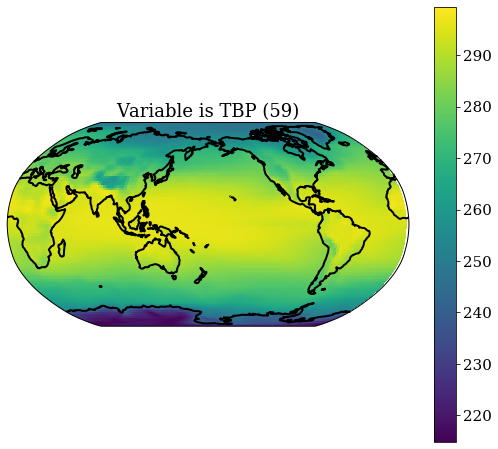

In [32]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(9,8))
imag = ax.pcolormesh(coor_RG.lon,coor_RG.lat,NST,transform=ccrs.PlateCarree())
plt.colorbar(imag)
ax.coastlines(linewidth=2.0,edgecolor='0.25')
#ax.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
plt.title('Variable is '+(train_data_raw['var_names'].values)[iNST]+' ('+str(iNST)+')');
plt.xlabel('Longitude');
plt.ylabel('Latitude');

## Reorganize TPHYSTND500 dataset to make it a time serie

In [12]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [13]:
path_train = path_data + '2022_01_19_TRAIN_M4K_TPHYSTND500.nc'
path_valid = path_data + '2022_01_19_VALID_M4K_TPHYSTND500.nc'
path_norm = path_data + '2022_01_20_NORM_TPHYSTND500.nc'

In [14]:
train_data_raw = xr.open_dataset(path_train)

In [15]:
raw_var_name = train_data_raw['var_names'].values

In [18]:
Nlat = 64
Nlon = 128
NT = int(train_data_raw['vars'].shape[0]/(Nlat*Nlon))
Ninp = 64 # with tendency at t-dt
Noup = 1
Nvars = Ninp+Noup
raw_vars_time = DT*np.arange(0,NT)/(24*3600)
N_toexclude = 0 

In [19]:
raw_vars = train_data_raw['vars'].values
raw_vars = np.reshape(raw_vars,(NT,Nlat,Nlon,Nvars))

In [20]:
inputs_idx = np.arange(0,Ninp)
output_idx = [Noup]

In [21]:
iNST = 59
NST = np.mean(raw_vars[:,:,:,iNST],axis=0)

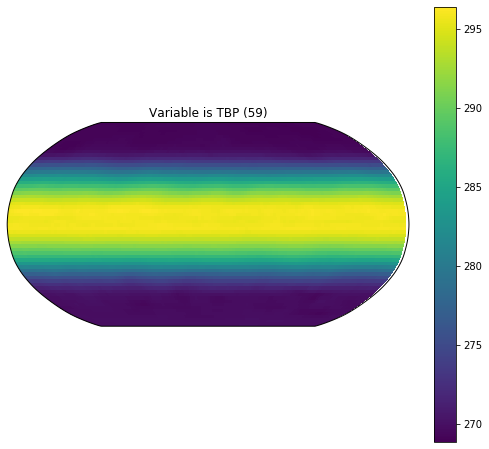

In [24]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(9,8))
imag = ax.pcolormesh(coor.lon,coor.lat,NST,transform=ccrs.PlateCarree())
plt.colorbar(imag)
plt.title('Variable is '+(train_data_raw['var_names'].values)[iNST]+' ('+str(iNST)+')');
plt.xlabel('Longitude');
plt.ylabel('Latitude');

## Reorganize climate-invariant version of TPHYSTND500 to make it a time series

In [72]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [73]:
path_train = path_data + '2022_01_20_TRAIN_CI_TPHYSTND500.nc'
path_valid = path_data + '2022_01_20_VALID_CI_TPHYSTND500.nc'
path_norm = path_data + '2022_01_20_NORM_TPHYSTND500.nc'

In [75]:
train_data_raw = xr.open_dataset(path_train)

In [76]:
raw_var_name = train_data_raw['var_names'].values

In [77]:
Nlat = 64
Nlon = 128
NT = int(train_data_raw['vars'].shape[0]/(Nlat*Nlon))
Ninp = 64 # with tendency at t-dt
Noup = 1
Nvars = Ninp+Noup
raw_vars_time = DT*np.arange(0,NT)/(24*3600)
N_toexclude = 0 

In [78]:
raw_vars = train_data_raw['vars'].values
raw_vars = np.reshape(raw_vars,(NT,Nlat,Nlon,Nvars))

In [79]:
inputs_idx = np.arange(0,Ninp)
output_idx = [Noup]

In [82]:
iNST = 55
NST = np.mean(raw_vars[:,:,:,iNST],axis=0)

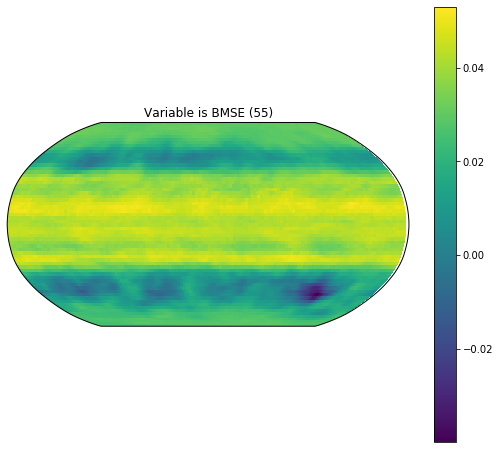

In [83]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(9,8))
imag = ax.pcolormesh(coor.lon,coor.lat,NST,transform=ccrs.PlateCarree())
plt.colorbar(imag)
plt.title('Variable is '+(train_data_raw['var_names'].values)[iNST]+' ('+str(iNST)+')');
plt.xlabel('Longitude');
plt.ylabel('Latitude');

# Circle of constant latitude

In [105]:
lat_test = 0
lon_test = 150

In [106]:
ilon = np.argmin(np.abs(lon_test-coor.lon.values))
ilat = np.argmin(np.abs(lat_test-coor.lat.values))

In [107]:
tau_min = 1
tau_max = 1
children = [Ninp-N_toexclude]
parents = np.arange(0,Ninp-N_toexclude)

In [108]:
sel_links = select_links(tau_min, tau_max, parents, children)

In [109]:
parcorr = ParCorr(significance='analytic')

## Brute-force mapping

### Without concatenating

In [129]:
par_raw_lat0 = {}
nlink = {}

In [135]:
for ilon in np.arange(0,128):
    par_raw_lat0[ilon] = {}
    nlink[ilon] = {}
    for ioup in np.arange(0,Noup-N_toexclude):
        ioup0 = Ninp0+N_toexclude+ioup
        print('ilon=',ilon,'and ioup=',ioup0,'          ',end='\r')
        raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
        raw_vars_oup = raw_vars[:-1,ilat,ilon,[ioup0]]
        raw_vars_combined = np.concatenate((raw_vars_inp,
                                            raw_vars_oup),axis=-1)
        raw_vars_nam = np.concatenate((raw_var_name[inputs_idx],
                                       [raw_var_name[ioup0]]))
        raw_vars_frame = pp.DataFrame(raw_vars_combined,datatime=raw_vars_time,
                                      var_names=raw_vars_nam)
        pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
        tmp = pcmci.run_pc_stable(selected_links = sel_links,
                                  tau_min = 1,tau_max=1,pc_alpha=0.01)
        par_raw_lat0[ilon][ioup0] = tmp[Ninp-N_toexclude]
        nlink[ilon][ioup0] = len(par_raw_lat0[ilon][ioup0])

Intersection of all parents

In [ ]:
par_raw_lat0_intersect = {}
nlink_intersect = {}

In [196]:
for ioup in np.arange(0,Noup-N_toexclude):
    ioup0 = Ninp0+N_toexclude+ioup
    print('ioup=',ioup0,'          ',end='\r')
    par_raw_lat0_intersect[ioup0] = {}
    for iinp in range(Ninp-N_toexclude):
        par_raw_lat0_intersect[ioup0][iinp] = 0
        for ilon in range(128):
            tmp = np.sum([(i[0]==iinp) for i in par_raw_lat0[ilon][ioup0]])
            par_raw_lat0_intersect[ioup0][iinp] = \
            (ilon*par_raw_lat0_intersect[ioup0][iinp]+tmp)/(ilon+1)
            
    nlink_intersect[ioup0] = \
    np.sum([par_raw_lat0_intersect[ioup0][i] for i \
            in par_raw_lat0_intersect[ioup0]])/(Ninp-N_toexclude)

### With concatenating

In [141]:
par_raw_lat0_concat = {}
nlink_concat = {}

In [156]:
for ioup in np.arange(0,Noup-N_toexclude):
    ioup0 = Ninp0+N_toexclude+ioup
    raw_vars_nam = np.concatenate((raw_var_name[inputs_idx],
                                   [raw_var_name[ioup0]]))
    
    # Initialize time series
    ilon = 0
    raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
    raw_vars_oup = raw_vars[:-1,ilat,ilon,[ioup0]]
    raw_vars_combined = np.concatenate((raw_vars_inp,
                                        raw_vars_oup),axis=-1)
    
    # Concatenate lon in the time direction to form a long time series
    for ilon in range(127):
        print('ioup=',ioup0,'& ilon=',ilon,'             ',end='\r')
        raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
        raw_vars_oup = raw_vars[:-1,ilat,ilon,[ioup0]]
        tmp = np.concatenate((raw_vars_inp,raw_vars_oup),axis=-1)
        raw_vars_combined = np.concatenate((raw_vars_combined,tmp),
                                           axis=0)
    
    raw_vars_frame = pp.DataFrame(raw_vars_combined,datatime=raw_vars_time,
                                  var_names=raw_vars_nam)
    pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
    tmp = pcmci.run_pc_stable(selected_links = sel_links,
                              tau_min = 1,tau_max=1,pc_alpha=0.01)
    par_raw_lat0_concat[ioup0] = tmp[Ninp-N_toexclude]
    nlink_concat[ioup0] = len(par_raw_lat0_concat[ioup0])

### With correlations (fully concatenated)

In [197]:
corr = {}

In [209]:
for ioup in np.arange(0,Noup-N_toexclude):
    ioup0 = Ninp0+N_toexclude+ioup
    
    raw_vars_nam = np.concatenate((raw_var_name[inputs_idx],
                                   [raw_var_name[ioup0]]))
    
    # Initialize time series
    ilon = 0
    raw_vars_inp = raw_vars[:,ilat,ilon,inputs_idx]
    raw_vars_oup = raw_vars[:,ilat,ilon,[ioup0]]
    raw_vars_combined = np.concatenate((raw_vars_inp,
                                        raw_vars_oup),axis=-1)
    
    # Concatenate lon in the time direction to form a long time series
    for ilon in range(127):
        print('ioup=',ioup0,'& ilon=',ilon,'             ',end='\r')
        raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
        raw_vars_oup = raw_vars[:-1,ilat,ilon,[ioup0]]
        tmp = np.concatenate((raw_vars_inp,raw_vars_oup),axis=-1)
        raw_vars_combined = np.concatenate((raw_vars_combined,tmp),
                                           axis=0)
    
    corr[ioup] = np.zeros((Ninp-N_toexclude,))
    for iinp in range(Ninp-N_toexclude):
        corr[ioup][iinp] = np.corrcoef(x=raw_vars_combined[:,iinp],
                                       y=raw_vars_combined[:,Ninp-N_toexclude])[0,1]

### Using SHAP

Load NN model

In [ ]:
path_HDF5 = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/HDF5_DATA/'
save_name = '2022_01_14_Test_Nando_BF_t-dt'

In [ ]:
model_BF = tf.keras.models.load_model(path_HDF5+save_name)

### Save links

In [210]:
save_name = '2022_01_14_lat0_BF'
hf = open(pathPKL+save_name+'.pkl','wb')

In [211]:
F_data = {'par_raw_lat0':par_raw_lat0,
         'nlink':nlink,
         'par_raw_lat0_intersect':par_raw_lat0_intersect,
         'nlink_intersect':nlink_intersect,
         'corr':corr}

pickle.dump(F_data,hf)
hf.close()

## Visualizations for brute-force mapping

In [269]:
raw_vars_nam_inp = train_data_raw['var_names'][inputs_idx].values
for ivar in range(3):
    for ilev in range(30):
        raw_vars_nam_inp[30*ivar+ilev] = \
        raw_vars_nam_inp[30*ivar+ilev] + \
        '%2.0f'%(coor.lev[ilev].values)

for ilev in range(30-N_toexclude):
    raw_vars_nam_inp[Ninp0+ilev] = raw_vars_nam_inp[Ninp0+ilev] + '%2.0f'%(coor.lev[ilev+2].values)
for ilev in range(30):
    raw_vars_nam_inp[Ninp0+30-N_toexclude+ilev] = \
    raw_vars_nam_inp[Ninp0+30-N_toexclude+ilev] + \
    '%2.0f'%(coor.lev[ilev].values)

raw_vars_nam_oup = train_data_raw['var_names'][Ninp0+np.arange(0,Noup)].values
for ivar in range(2):
    for ilev in range(30):
        raw_vars_nam_oup[30*ivar+ilev] = \
        raw_vars_nam_oup[30*ivar+ilev] + \
        '%2.0f'%(coor.lev[ilev].values)
raw_vars_nam_oup = raw_vars_nam_oup[2:]

In [321]:
raw_vars_nam_inp

array(['QBP 4', 'QBP 8', 'QBP14', 'QBP25', 'QBP38', 'QBP55', 'QBP72',
       'QBP88', 'QBP103', 'QBP122', 'QBP143', 'QBP168', 'QBP198',
       'QBP233', 'QBP274', 'QBP322', 'QBP379', 'QBP446', 'QBP525',
       'QBP610', 'QBP691', 'QBP763', 'QBP821', 'QBP860', 'QBP887',
       'QBP913', 'QBP936', 'QBP957', 'QBP976', 'QBP993', 'TBP 4', 'TBP 8',
       'TBP14', 'TBP25', 'TBP38', 'TBP55', 'TBP72', 'TBP88', 'TBP103',
       'TBP122', 'TBP143', 'TBP168', 'TBP198', 'TBP233', 'TBP274',
       'TBP322', 'TBP379', 'TBP446', 'TBP525', 'TBP610', 'TBP691',
       'TBP763', 'TBP821', 'TBP860', 'TBP887', 'TBP913', 'TBP936',
       'TBP957', 'TBP976', 'TBP993', 'VBP 4', 'VBP 8', 'VBP14', 'VBP25',
       'VBP38', 'VBP55', 'VBP72', 'VBP88', 'VBP103', 'VBP122', 'VBP143',
       'VBP168', 'VBP198', 'VBP233', 'VBP274', 'VBP322', 'VBP379',
       'VBP446', 'VBP525', 'VBP610', 'VBP691', 'VBP763', 'VBP821',
       'VBP860', 'VBP887', 'VBP913', 'VBP936', 'VBP957', 'VBP976',
       'VBP993', 'PS', 'SOLIN', 'SHF

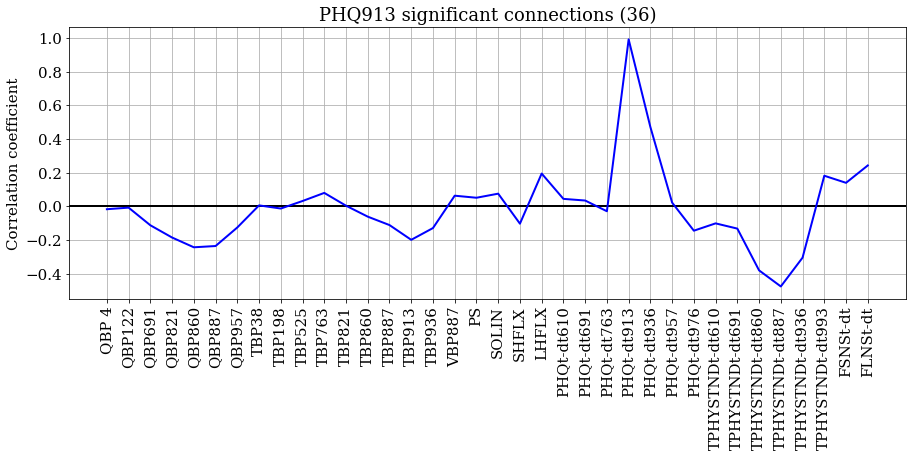

In [289]:
ioup = 23
ioup0 = Ninp0+N_toexclude+ioup

plt.figure(figsize=(15,5))
plt.axhline(y=0,color='k')
links = np.sort(np.array([i[0] for i in par_raw_lat0_concat[ioup0]]))
plt.plot(corr[ioup][links],color='b')
plt.xticks(np.arange(0,int(nlink_concat[ioup0])),
           raw_vars_nam_inp[links],
           rotation='vertical');
plt.title(raw_vars_nam_oup[ioup]+' significant connections ('+str(int(nlink_concat[ioup0]))+')')
plt.ylabel('Correlation coefficient')
plt.grid()

In [418]:
corr_array = np.zeros((Noup-N_toexclude,Ninp-N_toexclude))
link_array = np.zeros((Noup-N_toexclude,Ninp-N_toexclude))
link_latbylat = np.zeros((Noup-N_toexclude,Ninp-N_toexclude))
for ioup in range(Noup-N_toexclude):
    ioup0 = Ninp0+N_toexclude+ioup
    links = np.array([i[0] for i in par_raw_lat0_concat[ioup0]])
    corr_array[ioup,:] = corr[ioup]
    link_array[ioup,links] = 1
    for iinp in range(Ninp-N_toexclude):
        link_latbylat[ioup,iinp] = par_raw_lat0_intersect[ioup0][iinp]

Text(0.5, 0, 'Input index')

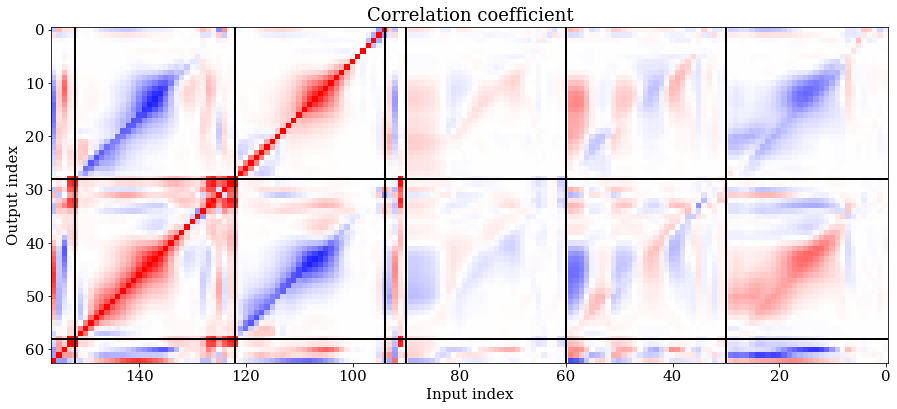

In [419]:
plt.figure(figsize=(15,15))
plt.imshow(corr_array,cmap='bwr',vmin=-1,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')
plt.gca().invert_xaxis()
plt.title('Correlation coefficient')
plt.ylabel('Output index')
plt.xlabel('Input index')

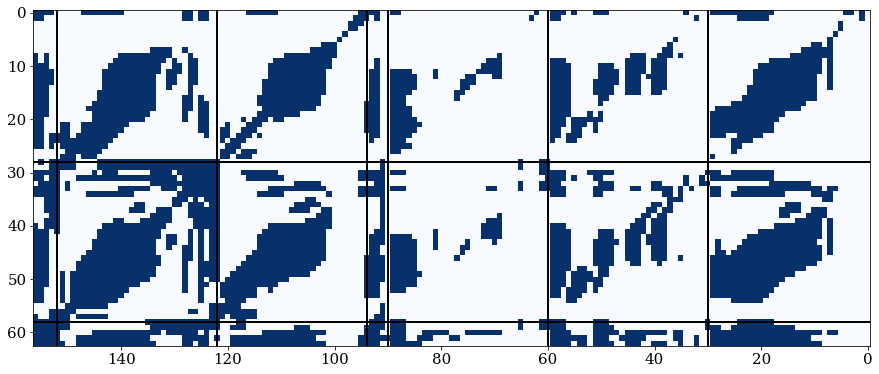

In [345]:
plt.figure(figsize=(15,15))
plt.imshow(np.abs(corr_array)>0.1,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')
plt.gca().invert_xaxis()

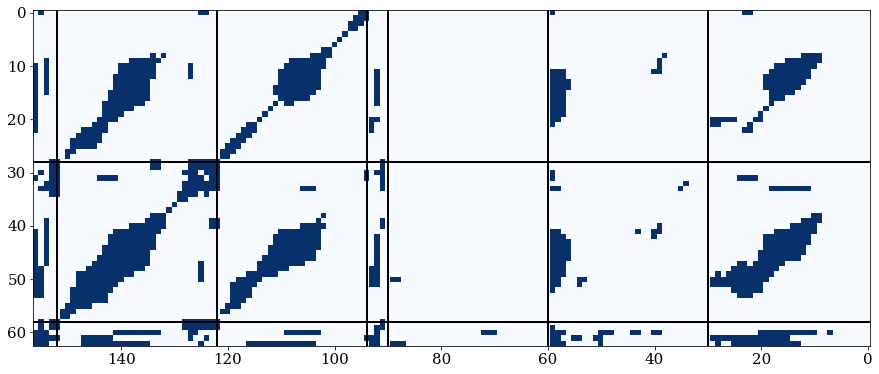

In [344]:
plt.figure(figsize=(15,15))
plt.imshow(np.abs(corr_array)>0.25,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')
plt.gca().invert_xaxis()

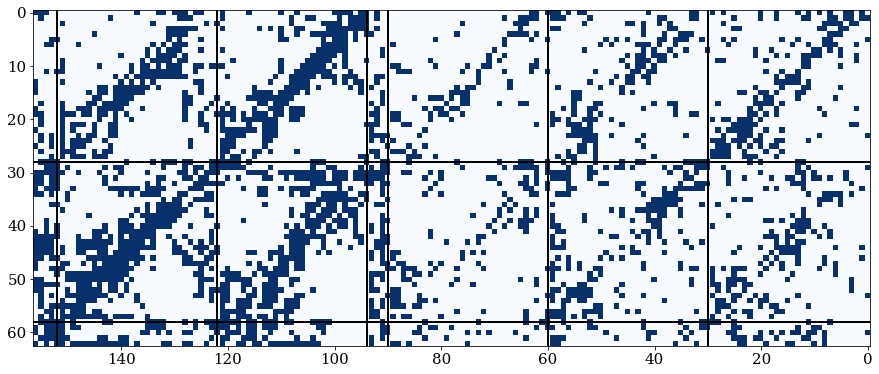

In [320]:
plt.figure(figsize=(15,15))
plt.imshow(link_array,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

plt.gca().invert_xaxis()

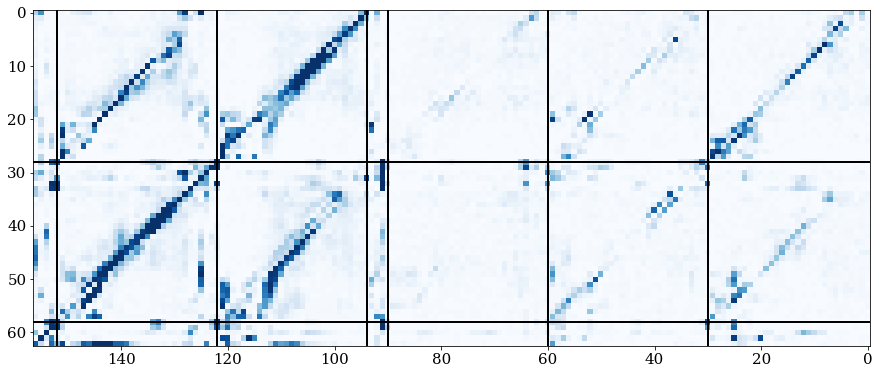

In [325]:
plt.figure(figsize=(15,15))
plt.imshow(link_latbylat,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

plt.gca().invert_xaxis()

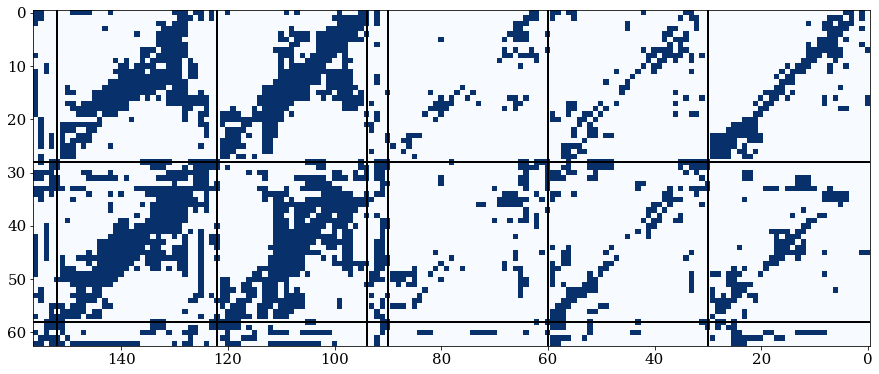

In [336]:
plt.figure(figsize=(15,15))
plt.imshow(link_latbylat>0.05,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

plt.gca().invert_xaxis()

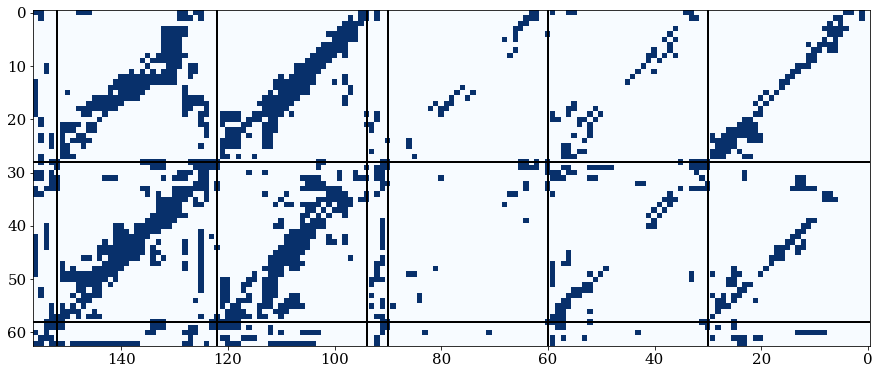

In [335]:
plt.figure(figsize=(15,15))
plt.imshow(link_latbylat>0.1,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

plt.gca().invert_xaxis()

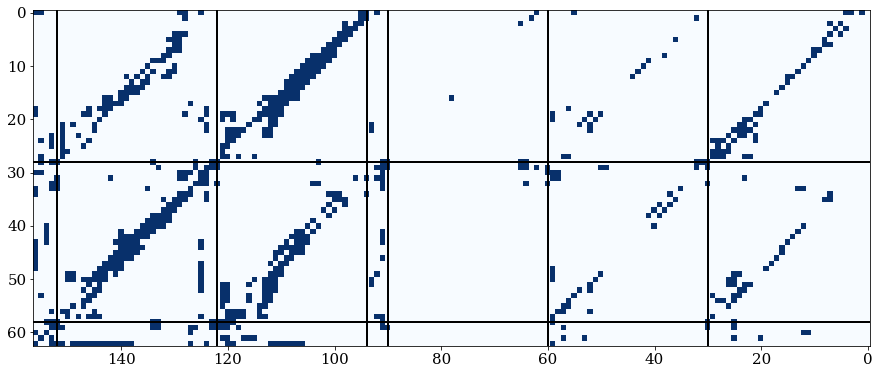

In [337]:
plt.figure(figsize=(15,15))
plt.imshow(link_latbylat>0.25,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

plt.gca().invert_xaxis()

## Climate-invariant mapping

# Circle of constant longitude

In [347]:
lat_test = 0
lon_test = 150

In [348]:
ilon = np.argmin(np.abs(lon_test-coor.lon.values))
ilat = np.argmin(np.abs(lat_test-coor.lat.values))

In [349]:
tau_min = 1
tau_max = 1
children = [Ninp-N_toexclude]
parents = np.arange(0,Ninp-N_toexclude)

In [350]:
sel_links = select_links(tau_min, tau_max, parents, children)

In [351]:
parcorr = ParCorr(significance='analytic')

## Brute-force mapping

### Without concatenating

In [359]:
par_raw_lon0 = {}
nlink = {}

In [390]:
for ilat in np.arange(56,64):
    par_raw_lon0[ilat] = {}
    nlink[ilat] = {}
    for ioup in np.arange(0,Noup-N_toexclude):
        ioup0 = Ninp0+N_toexclude+ioup
        print('ilat=',ilat,'and ioup=',ioup0,'          ',end='\r')
        raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
        
        # Add noise to SW variables when insolation is zero
        for ii,iinp in enumerate([91,152,153]):
            raw_vars_inp[:,iinp] += 1e-6*np.random.rand(raw_vars_inp[:,iinp].shape[0])        
        
        raw_vars_oup = raw_vars[:-1,ilat,ilon,[ioup0]]
        if ioup0 in ([154,155]): raw_vars_oup += 1e-6*np.random.rand(raw_vars_oup.shape[0],1) 
        raw_vars_combined = np.concatenate((raw_vars_inp,
                                            raw_vars_oup),axis=-1)
        raw_vars_nam = np.concatenate((raw_var_name[inputs_idx],
                                       [raw_var_name[ioup0]]))
        raw_vars_frame = pp.DataFrame(raw_vars_combined,datatime=raw_vars_time,
                                      var_names=raw_vars_nam)
        pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
        tmp = pcmci.run_pc_stable(selected_links = sel_links,
                                  tau_min = 1,tau_max=1,pc_alpha=0.01)
        par_raw_lon0[ilat][ioup0] = tmp[Ninp-N_toexclude]
        nlink[ilat][ioup0] = len(par_raw_lon0[ilat][ioup0])

In [385]:
raw_vars_oup.shape

(5758, 1)

In [391]:
par_raw_lon0_intersect = {}
nlink_intersect = {}

In [392]:
for ioup in np.arange(0,Noup-N_toexclude):
    ioup0 = Ninp0+N_toexclude+ioup
    print('ioup=',ioup0,'          ',end='\r')
    par_raw_lon0_intersect[ioup0] = {}
    for iinp in range(Ninp-N_toexclude):
        par_raw_lon0_intersect[ioup0][iinp] = 0
        for ilat in range(64):
            tmp = np.sum([(i[0]==iinp) for i in par_raw_lon0[ilat][ioup0]])
            par_raw_lon0_intersect[ioup0][iinp] = \
            (ilon*par_raw_lon0_intersect[ioup0][iinp]+tmp)/(ilon+1)
            
    nlink_intersect[ioup0] = \
    np.sum([par_raw_lon0_intersect[ioup0][i] for i \
            in par_raw_lon0_intersect[ioup0]])/(Ninp-N_toexclude)

### With concatenating

In [402]:
par_raw_lon0_concat = {}
nlink_concat = {}

In [ ]:
for ioup in np.arange(0,Noup-N_toexclude):
    ioup0 = Ninp0+N_toexclude+ioup
    raw_vars_nam = np.concatenate((raw_var_name[inputs_idx],
                                   [raw_var_name[ioup0]]))
    
    # Initialize time series
    ilat = 0
    raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
    
    # Add noise to SW variables when insolation is zero
    for ii,iinp in enumerate([91,152,153]):
        raw_vars_inp[:,iinp] += 1e-6*np.random.rand(raw_vars_inp[:,iinp].shape[0])        
    
    raw_vars_oup = raw_vars[:-1,ilat,ilon,[ioup0]]
    raw_vars_combined = np.concatenate((raw_vars_inp,
                                        raw_vars_oup),axis=-1)
    
    # Concatenate lon in the time direction to form a long time series
    for ilat in range(63):
        print('ioup=',ioup0,'& ilat=',ilat,'             ',end='\r')
        raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
        
        # Add noise to SW variables when insolation is zero
        for ii,iinp in enumerate([91,152,153]):
            raw_vars_inp[:,iinp] += 1e-6*np.random.rand(raw_vars_inp[:,iinp].shape[0]) 
        
        raw_vars_oup = raw_vars[:-1,ilat,ilon,[ioup0]]
        tmp = np.concatenate((raw_vars_inp,raw_vars_oup),axis=-1)
        raw_vars_combined = np.concatenate((raw_vars_combined,tmp),
                                           axis=0)
    
    raw_vars_frame = pp.DataFrame(raw_vars_combined,datatime=raw_vars_time,
                                  var_names=raw_vars_nam)
    pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
    tmp = pcmci.run_pc_stable(selected_links = sel_links,
                              tau_min = 1,tau_max=1,pc_alpha=0.01)
    par_raw_lon0_concat[ioup0] = tmp[Ninp-N_toexclude]
    nlink_concat[ioup0] = len(par_raw_lon0_concat[ioup0])

In [439]:
raw_vars_nam[[91,152,153]]

array(['SOLIN', 'FSNTt-dt', 'FSNSt-dt'], dtype=object)

### With correlations (fully concatenated)

In [393]:
corr_lon0 = {}

In [397]:
for ioup in np.arange(0,Noup-N_toexclude):
    ioup0 = Ninp0+N_toexclude+ioup
    
    raw_vars_nam = np.concatenate((raw_var_name[inputs_idx],
                                   [raw_var_name[ioup0]]))
    
    # Initialize time series
    ilat = 0
    raw_vars_inp = raw_vars[:,ilat,ilon,inputs_idx]
    raw_vars_oup = raw_vars[:,ilat,ilon,[ioup0]]
    raw_vars_combined = np.concatenate((raw_vars_inp,
                                        raw_vars_oup),axis=-1)
    
    # Concatenate lon in the time direction to form a long time series
    for ilat in range(63):
        print('ioup=',ioup0,'& ilat=',ilat,'             ',end='\r')
        raw_vars_inp = raw_vars[1:,ilat,ilon,inputs_idx]
        raw_vars_oup = raw_vars[:-1,ilat,ilon,[ioup0]]
        tmp = np.concatenate((raw_vars_inp,raw_vars_oup),axis=-1)
        raw_vars_combined = np.concatenate((raw_vars_combined,tmp),
                                           axis=0)
    
    corr_lon0[ioup] = np.zeros((Ninp-N_toexclude,))
    for iinp in range(Ninp-N_toexclude):
        corr_lon0[ioup][iinp] = np.corrcoef(x=raw_vars_combined[:,iinp],
                                       y=raw_vars_combined[:,Ninp-N_toexclude])[0,1]

### Save links

In [410]:
save_name = '2022_01_16_lon0_BF'
hf = open(pathPKL+save_name+'.pkl','wb')

In [411]:
F_data = {'par_raw_lon0':par_raw_lat0,
         'nlink':nlink,
         'par_raw_lon0_intersect':par_raw_lat0_intersect,
         'nlink_intersect':nlink_intersect,
         'corr_lon0':corr_lon0}

pickle.dump(F_data,hf)
hf.close()

## Visualizations for brute-force mapping

In [420]:
corr_array = np.zeros((Noup-N_toexclude,Ninp-N_toexclude))
#link_array = np.zeros((Noup-N_toexclude,Ninp-N_toexclude))
link_latbylat = np.zeros((Noup-N_toexclude,Ninp-N_toexclude))
for ioup in range(Noup-N_toexclude):
    ioup0 = Ninp0+N_toexclude+ioup
    #links = np.array([i[0] for i in par_raw_lon0_concat[ioup0]])
    corr_array[ioup,:] = corr_lon0[ioup]
    #link_array[ioup,links] = 1
    for iinp in range(Ninp-N_toexclude):
        link_latbylat[ioup,iinp] = par_raw_lon0_intersect[ioup0][iinp]

Text(0.5, 0, 'Input index')

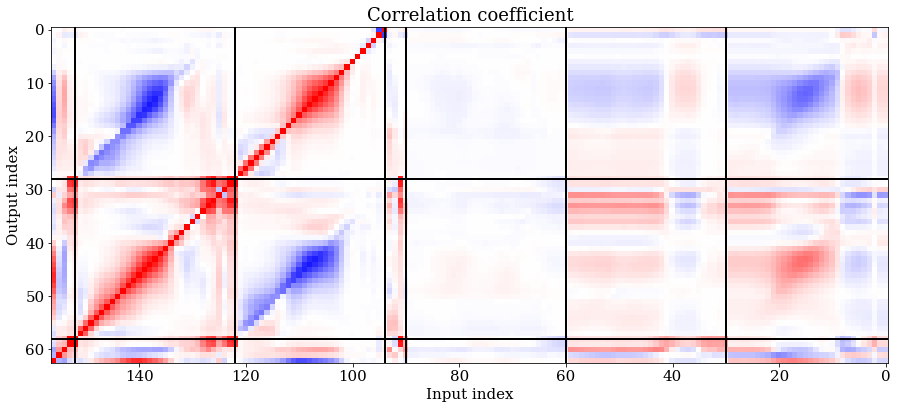

In [421]:
plt.figure(figsize=(15,15))
plt.imshow(corr_array,cmap='bwr',vmin=-1,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')
plt.gca().invert_xaxis()
plt.title('Correlation coefficient')
plt.ylabel('Output index')
plt.xlabel('Input index')

Text(0.5, 0, 'Input index')

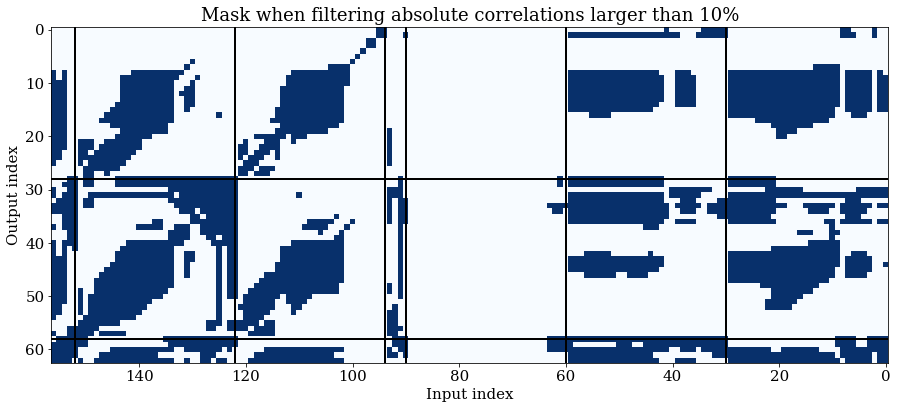

In [436]:
prop = 10

plt.figure(figsize=(15,15))
plt.imshow(np.abs(corr_array)>prop/100,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')
plt.gca().invert_xaxis()

plt.title('Mask when filtering absolute correlations larger than '+str(prop)+'%')
plt.ylabel('Output index')
plt.xlabel('Input index')

Text(0.5, 0, 'Input index')

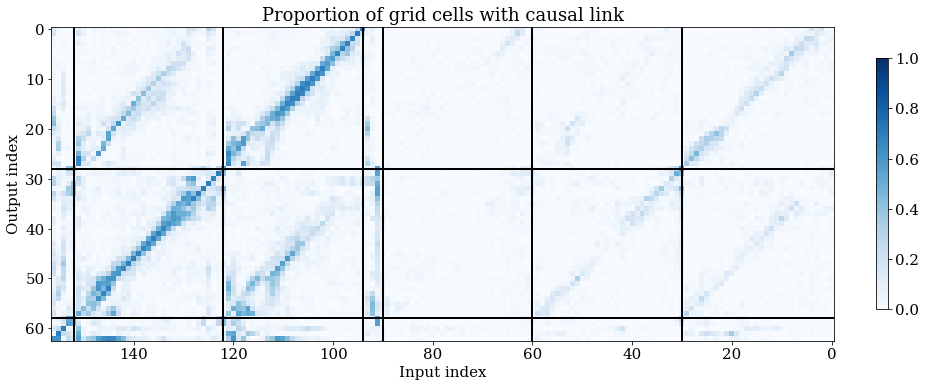

In [429]:
plt.figure(figsize=(15,15))
plt.imshow(link_latbylat,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

C = plt.colorbar(fraction=0.015)
plt.gca().invert_xaxis()
plt.title('Proportion of grid cells with causal link')
plt.ylabel('Output index')
plt.xlabel('Input index')

Text(0.5, 0, 'Input index')

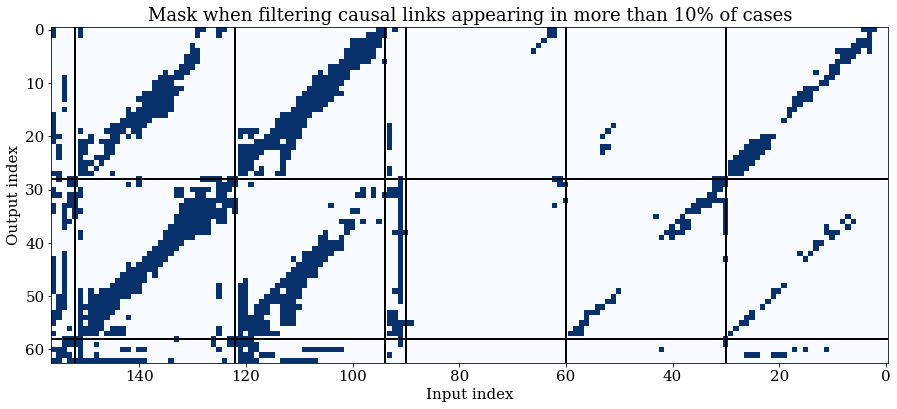

In [440]:
prop = 10
plt.figure(figsize=(15,15))
plt.imshow(link_latbylat>prop/100,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

plt.gca().invert_xaxis()
plt.title('Mask when filtering causal links appearing in more than '+str(prop)+'% of cases')
plt.ylabel('Output index')
plt.xlabel('Input index')

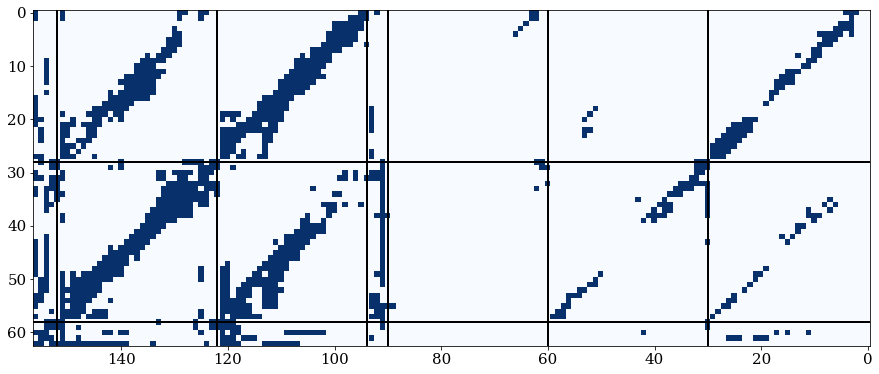

In [417]:
plt.figure(figsize=(15,15))
plt.imshow(link_latbylat>0.1,cmap='Blues',vmin=0,vmax=1)
for iy,y0 in enumerate([28,58]):
    plt.axhline(y=y0,color='k')
for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
    plt.axvline(x=x0,color='k')

plt.gca().invert_xaxis()

## Climate-invariant mapping

# Causal links for PRECT

## Brute force

In [35]:
tau_min = 1
tau_max = 1
children = [Ninp]
parents = np.arange(0,Ninp)

sel_links = select_links(tau_min, tau_max, parents, children)
parcorr = ParCorr(significance='analytic')

In [36]:
cl_PRECT = {}
nlink = {}

In [40]:
nam = train_data_raw['var_names'].values

In [50]:
for ivar in range(2):
    for ilev in range(30):
        nam[30*ivar+ilev] = nam[30*ivar+ilev] + '%2.0f'%(coor.lev[ilev].values)

In [51]:
nam

array(['QBP 4', 'QBP 8', 'QBP14', 'QBP25', 'QBP38', 'QBP55', 'QBP72',
       'QBP88', 'QBP103', 'QBP122', 'QBP143', 'QBP168', 'QBP198',
       'QBP233', 'QBP274', 'QBP322', 'QBP379', 'QBP446', 'QBP525',
       'QBP610', 'QBP691', 'QBP763', 'QBP821', 'QBP860', 'QBP887',
       'QBP913', 'QBP936', 'QBP957', 'QBP976', 'QBP993', 'TBP 4', 'TBP 8',
       'TBP14', 'TBP25', 'TBP38', 'TBP55', 'TBP72', 'TBP88', 'TBP103',
       'TBP122', 'TBP143', 'TBP168', 'TBP198', 'TBP233', 'TBP274',
       'TBP322', 'TBP379', 'TBP446', 'TBP525', 'TBP610', 'TBP691',
       'TBP763', 'TBP821', 'TBP860', 'TBP887', 'TBP913', 'TBP936',
       'TBP957', 'TBP976', 'TBP993', 'PS', 'SOLIN', 'SHFLX', 'LHFLX',
       'PRECTt-dt', 'PRECT'], dtype=object)

In [52]:
for ilat in np.arange(0,Nlat):
    cl_PRECT[ilat] = {}
    nlink[ilat] = {}
    for ilon in np.arange(0,Nlon):
        cl_PRECT[ilat][ilon] = {}
        nlink[ilat][ilon] = {}
        print('ilat=',ilat,'and ilon=',ilon,'          ',end='\r')
        
        raw_vars_inp = raw_vars[1:,ilat,ilon,parents]
        raw_vars_oup = raw_vars[:-1,ilat,ilon,children]
        raw_vars_combined = np.concatenate((raw_vars_inp,
                                            raw_vars_oup),axis=-1)
        raw_vars_frame = pp.DataFrame(raw_vars_combined,datatime=raw_vars_time,
                                      var_names=nam)
        pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
        tmp = pcmci.run_pc_stable(selected_links = sel_links,
                                  tau_min = 1,tau_max=1,pc_alpha=0.01)
        cl_PRECT[ilat][ilon] = tmp[Ninp]
        nlink[ilat][ilon] = len(cl_PRECT[ilat][ilon])

In [53]:
cl_PRECT_intersect = {}
nlink_intersect = {}

In [54]:
for iinp in range(Ninp):
    cl_PRECT_intersect[iinp] = 0
    icount = 0
    for ilat in range(Nlat):
        for ilon in range(Nlon):
            tmp = np.sum([(i[0]==iinp) for i in cl_PRECT[ilat][ilon]])
            cl_PRECT_intersect[iinp] = \
            (icount*cl_PRECT_intersect[iinp]+tmp)/(icount+1)
            icount += 1
            
nlink_intersect = np.sum([cl_PRECT_intersect[i] for i in cl_PRECT_intersect])/Ninp

In [61]:
corr = {}

In [58]:
raw_vars.shape

(10356, 96, 144, 66)

In [59]:
# Flatten lon,lat dimension
raw_vars_cor = np.reshape(raw_vars,(10356*96*144,66))

In [63]:
for iinp in range(Ninp):
    print(iinp)
    corr[iinp] = np.corrcoef(x=raw_vars_cor[:,iinp],y=raw_vars_cor[:,Ninp])[0,1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [64]:
corr

{0: -0.06462144218176939,
 1: -0.08283230633112354,
 2: -0.022422513817380786,
 3: -0.008079633246567316,
 4: -0.017397659346907485,
 5: -0.03356410026736414,
 6: -0.05534140124862622,
 7: -0.07886099674572784,
 8: -0.08953995434562548,
 9: -0.07330010632702631,
 10: 0.01660794908108474,
 11: 0.17535085099207498,
 12: 0.2636358737441267,
 13: 0.30215446321697853,
 14: 0.33492759521090015,
 15: 0.36914117154033976,
 16: 0.3975936913180209,
 17: 0.42097329558159213,
 18: 0.4304799714127584,
 19: 0.41686400398913825,
 20: 0.38535188357012906,
 21: 0.343726546450958,
 22: 0.30487033152776516,
 23: 0.2814251114927334,
 24: 0.2654405022168129,
 25: 0.2511431926179906,
 26: 0.24140974383869557,
 27: 0.23844699070218855,
 28: 0.2379579518938975,
 29: 0.23747830844770249,
 30: 0.04646987597047251,
 31: 0.03744787715564748,
 32: 0.045623711649857054,
 33: 0.030892046934638484,
 34: -0.017702012103225282,
 35: -0.06952388857308606,
 36: -0.09510311989828031,
 37: -0.10951846016414152,
 38: -0.118

In [66]:
corr_array = np.zeros((Ninp,))
#link_array = np.zeros((Noup-N_toexclude,Ninp-N_toexclude))
link_locbyloc = np.zeros((Ninp,))
#link_array[ioup,links] = 1
for iinp in range(Ninp):
    corr_array[iinp] = corr[iinp]
    link_locbyloc[iinp] = cl_PRECT_intersect[iinp]

Text(0.5, 0, 'Input index')

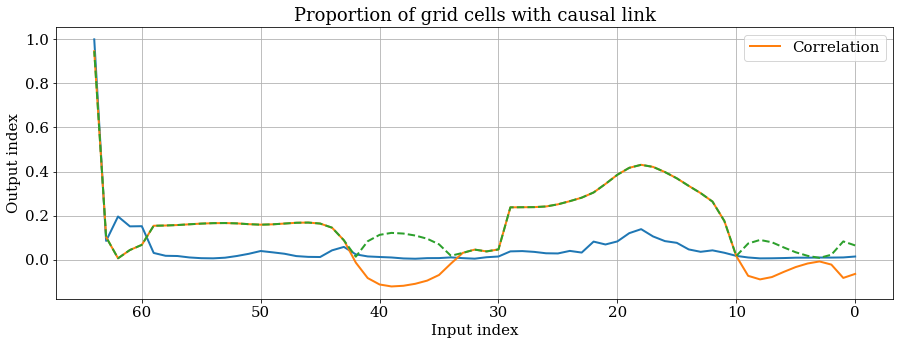

In [77]:
plt.figure(figsize=(15,5))
plt.plot(link_locbyloc)
plt.plot(corr_array,label='Correlation')
plt.plot(np.abs(corr_array),linestyle='--')
# for iy,y0 in enumerate([28,58]):
#     plt.axhline(y=y0,color='k')
# for ix,x0 in enumerate([30,60,90,90+4,90+4+28,90+4+28+30]):
#     plt.axvline(x=x0,color='k')

# C = plt.colorbar(fraction=0.015)
plt.gca().invert_xaxis()
plt.grid()
plt.legend()
plt.title('Proportion of grid cells with causal link')
plt.ylabel('Output index')
plt.xlabel('Input index')

In [78]:
save_name = '2022_01_19_BF_PRECTt-dt_links'
hf = open(pathPKL+save_name+'.pkl','wb')

In [79]:
F_data = {'cl_PRECT':cl_PRECT,
         'nlink':nlink,
         'cl_PRECT_intersect':cl_PRECT_intersect,
         'nlink_intersect':nlink_intersect,
         'corr':corr}

pickle.dump(F_data,hf)
hf.close()

In [80]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

             raw_vars_combined:  2.6 MiB
                 raw_vars_time: 81.0 KiB
                           NST: 54.1 KiB
                      cl_PRECT:  4.6 KiB
                         nlink:  4.6 KiB
                     sel_links:  2.2 KiB
                           _42:  2.2 KiB
                           _43:  2.2 KiB
            cl_PRECT_intersect:  2.2 KiB
                          corr:  2.2 KiB


# Causal links for TPHYSTND500

## Brute force

In [25]:
tau_min = 1
tau_max = 1
children = [Ninp]
parents = np.arange(0,Ninp)

In [26]:
sel_links = select_links(tau_min, tau_max, parents, children)
parcorr = ParCorr(significance='analytic')

In [29]:
cl_TPHYSTND500 = {}
nlink = {}

In [30]:
nam = train_data_raw['var_names'].values

In [31]:
for ivar in range(2):
    for ilev in range(30):
        nam[30*ivar+ilev] = nam[30*ivar+ilev] + '%2.0f'%(coor.lev[ilev].values)

In [32]:
nam

array(['QBP 4', 'QBP 8', 'QBP14', 'QBP25', 'QBP38', 'QBP55', 'QBP72',
       'QBP88', 'QBP103', 'QBP122', 'QBP143', 'QBP168', 'QBP198',
       'QBP233', 'QBP274', 'QBP322', 'QBP379', 'QBP446', 'QBP525',
       'QBP610', 'QBP691', 'QBP763', 'QBP821', 'QBP860', 'QBP887',
       'QBP913', 'QBP936', 'QBP957', 'QBP976', 'QBP993', 'TBP 4', 'TBP 8',
       'TBP14', 'TBP25', 'TBP38', 'TBP55', 'TBP72', 'TBP88', 'TBP103',
       'TBP122', 'TBP143', 'TBP168', 'TBP198', 'TBP233', 'TBP274',
       'TBP322', 'TBP379', 'TBP446', 'TBP525', 'TBP610', 'TBP691',
       'TBP763', 'TBP821', 'TBP860', 'TBP887', 'TBP913', 'TBP936',
       'TBP957', 'TBP976', 'TBP993', 'PS', 'SOLIN', 'SHFLX', 'LHFLX',
       'TPHYSTND500'], dtype=object)

In [41]:
np.std(raw_vars_combined[:,-4],axis=0)

0.0

In [42]:
for ilat in np.arange(56,Nlat):
    cl_TPHYSTND500[ilat] = {}
    nlink[ilat] = {}
    for ilon in np.arange(0,Nlon):
        cl_TPHYSTND500[ilat][ilon] = {}
        nlink[ilat][ilon] = {}
        print('ilat=',ilat,'and ilon=',ilon,'          ',end='\r')
        
        raw_vars_inp = raw_vars[1:,ilat,ilon,parents]
        raw_vars_oup = raw_vars[:-1,ilat,ilon,children]
        raw_vars_combined = np.concatenate((raw_vars_inp,
                                            raw_vars_oup),axis=-1)
        raw_vars_combined[:,-4] += 1e-6*np.random.rand(raw_vars_combined.shape[0])        
        raw_vars_frame = pp.DataFrame(raw_vars_combined,datatime=raw_vars_time,
                                      var_names=nam)
        pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
        tmp = pcmci.run_pc_stable(selected_links = sel_links,
                                  tau_min = 1,tau_max=1,pc_alpha=0.01)
        cl_TPHYSTND500[ilat][ilon] = tmp[Ninp]
        nlink[ilat][ilon] = len(cl_TPHYSTND500[ilat][ilon])

In [43]:
cl_TPHYSTND500_intersect = {}
nlink_intersect = {}

In [44]:
for iinp in range(Ninp):
    cl_TPHYSTND500_intersect[iinp] = 0
    icount = 0
    for ilat in range(Nlat):
        for ilon in range(Nlon):
            tmp = np.sum([(i[0]==iinp) for i in cl_TPHYSTND500[ilat][ilon]])
            cl_TPHYSTND500_intersect[iinp] = \
            (icount*cl_TPHYSTND500_intersect[iinp]+tmp)/(icount+1)
            icount += 1

In [45]:
nlink_intersect = np.sum([cl_TPHYSTND500_intersect[i] for i in cl_TPHYSTND500_intersect])/Ninp

In [51]:
corr = {}

In [52]:
# Flatten lon,lat dimension
raw_vars_cor = np.reshape(raw_vars,(NT*Nlon*Nlat,Ninp+1))

for iinp in range(Ninp):
    print(iinp)
    corr[iinp] = np.corrcoef(x=raw_vars_cor[:,iinp],y=raw_vars_cor[:,Ninp])[0,1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [53]:
corr_array = np.zeros((Ninp,))
#link_array = np.zeros((Noup-N_toexclude,Ninp-N_toexclude))
link_locbyloc = np.zeros((Ninp,))
#link_array[ioup,links] = 1
for iinp in range(Ninp):
    corr_array[iinp] = corr[iinp]
    link_locbyloc[iinp] = cl_TPHYSTND500_intersect[iinp]

Text(0.5, 0, 'Input index')

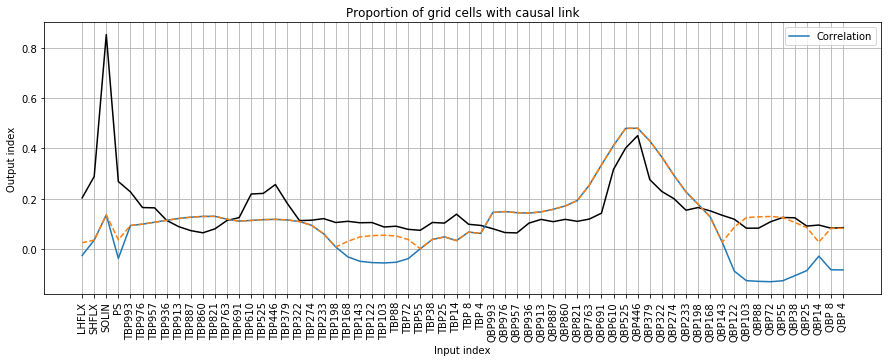

In [58]:
plt.figure(figsize=(15,5))
plt.plot(link_locbyloc,color='k')
plt.plot(corr_array,label='Correlation')
plt.plot(np.abs(corr_array),linestyle='--')
plt.gca().invert_xaxis()
plt.grid()
plt.legend()
plt.xticks(np.arange(0,Ninp),
           nam,rotation='vertical');
plt.title('Proportion of grid cells with causal link')
plt.ylabel('Output index')
plt.xlabel('Input index')

In [64]:
nam[:-1][link_locbyloc>0.2]

array(['QBP274', 'QBP322', 'QBP379', 'QBP446', 'QBP525', 'QBP610',
       'TBP446', 'TBP525', 'TBP610', 'TBP993', 'PS', 'SOLIN', 'SHFLX',
       'LHFLX'], dtype=object)

In [68]:
nam[:-1][np.abs(corr_array)>0.15]

array(['QBP198', 'QBP233', 'QBP274', 'QBP322', 'QBP379', 'QBP446',
       'QBP525', 'QBP610', 'QBP691', 'QBP763', 'QBP821', 'QBP860',
       'QBP887'], dtype=object)

In [70]:
save_name = '2022_01_20_BF_TPHYSTND500_links'
hf = open(pathPKL+save_name+'.pkl','wb')

In [71]:
F_data = {'cl_TPHYSTND500':cl_TPHYSTND500,
         'nlink':nlink,
         'cl_TPHYSTND500_intersect':cl_TPHYSTND500_intersect,
         'nlink_intersect':nlink_intersect,
         'corr_array':corr_array,
         'link_locbyloc':link_locbyloc,
         'nam':nam}

pickle.dump(F_data,hf)
hf.close()

## Climate-invariant

In [84]:
tau_min = 1
tau_max = 1
children = [Ninp]
parents = np.arange(0,Ninp)

In [85]:
sel_links = select_links(tau_min, tau_max, parents, children)
parcorr = ParCorr(significance='analytic')

In [86]:
clCI_TPHYSTND500 = {}
nlink = {}

In [87]:
nam = train_data_raw['var_names'].values

for ivar in range(2):
    for ilev in range(30):
        nam[30*ivar+ilev] = nam[30*ivar+ilev] + '%2.0f'%(coor.lev[ilev].values)

In [90]:
for ilat in np.arange(0,Nlat):
    clCI_TPHYSTND500[ilat] = {}
    nlink[ilat] = {}
    for ilon in np.arange(0,Nlon):
        clCI_TPHYSTND500[ilat][ilon] = {}
        nlink[ilat][ilon] = {}
        print('ilat=',ilat,'and ilon=',ilon,'          ',end='\r')
        
        raw_vars_inp = raw_vars[1:,ilat,ilon,parents]
        raw_vars_oup = raw_vars[:-1,ilat,ilon,children]
        raw_vars_combined = np.concatenate((raw_vars_inp,
                                            raw_vars_oup),axis=-1)
        for iinp in ([59,61]):
            raw_vars_combined[:,iinp] += 1e-6*np.random.rand(raw_vars_combined.shape[0])
        raw_vars_frame = pp.DataFrame(raw_vars_combined,datatime=raw_vars_time,
                                      var_names=nam)
        pcmci = PCMCI(dataframe=raw_vars_frame,cond_ind_test=parcorr,verbosity=0);
        tmp = pcmci.run_pc_stable(selected_links = sel_links,
                                  tau_min = 1,tau_max=1,pc_alpha=0.01)
        clCI_TPHYSTND500[ilat][ilon] = tmp[Ninp]
        nlink[ilat][ilon] = len(clCI_TPHYSTND500[ilat][ilon])

In [91]:
clCI_TPHYSTND500_intersect = {}
nlink_intersect = {}

In [92]:
for iinp in range(Ninp):
    clCI_TPHYSTND500_intersect[iinp] = 0
    icount = 0
    for ilat in range(Nlat):
        for ilon in range(Nlon):
            tmp = np.sum([(i[0]==iinp) for i in clCI_TPHYSTND500[ilat][ilon]])
            clCI_TPHYSTND500_intersect[iinp] = \
            (icount*clCI_TPHYSTND500_intersect[iinp]+tmp)/(icount+1)
            icount += 1

nlink_intersect = np.sum([clCI_TPHYSTND500_intersect[i] for i in clCI_TPHYSTND500_intersect])/Ninp

In [93]:
corr = {}

In [94]:
# Flatten lon,lat dimension
raw_vars_cor = np.reshape(raw_vars,(NT*Nlon*Nlat,Ninp+1))

for iinp in range(Ninp):
    print(iinp)
    corr[iinp] = np.corrcoef(x=raw_vars_cor[:,iinp],y=raw_vars_cor[:,Ninp])[0,1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


In [95]:
corr_array = np.zeros((Ninp,))
#link_array = np.zeros((Noup-N_toexclude,Ninp-N_toexclude))
link_locbyloc = np.zeros((Ninp,))
#link_array[ioup,links] = 1
for iinp in range(Ninp):
    corr_array[iinp] = corr[iinp]
    link_locbyloc[iinp] = clCI_TPHYSTND500_intersect[iinp]

Text(0.5, 0, 'Input index')

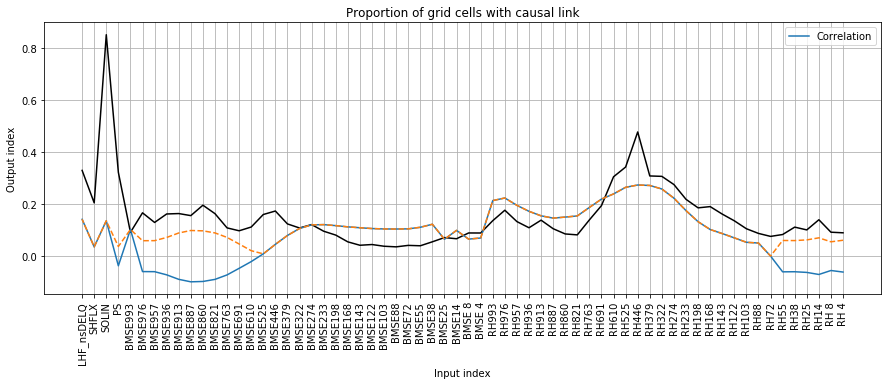

In [99]:
plt.figure(figsize=(15,5))
plt.plot(link_locbyloc,color='k')
plt.plot(corr_array,label='Correlation')
plt.plot(np.abs(corr_array),linestyle='--')
plt.gca().invert_xaxis()
plt.grid()
plt.legend()
plt.xticks(np.arange(0,Ninp),
           nam,rotation='vertical');
plt.title('Proportion of grid cells with causal link')
plt.ylabel('Output index')
plt.xlabel('Input index')

In [105]:
nam[:-1][link_locbyloc>0.2]

array(['RH233', 'RH274', 'RH322', 'RH379', 'RH446', 'RH525', 'RH610',
       'PS', 'SOLIN', 'SHFLX', 'LHF_nsDELQ'], dtype=object)

In [103]:
nam[:-1][np.abs(corr_array)>0.15]

array(['RH233', 'RH274', 'RH322', 'RH379', 'RH446', 'RH525', 'RH610',
       'RH691', 'RH763', 'RH821', 'RH860', 'RH913', 'RH936', 'RH957',
       'RH976', 'RH993'], dtype=object)

In [100]:
save_name = '2022_01_20_CI_TPHYSTND500_links'
hf = open(pathPKL+save_name+'.pkl','wb')

In [101]:
F_data = {'cl_TPHYSTND500':cl_TPHYSTND500,
         'nlink':nlink,
         'cl_TPHYSTND500_intersect':cl_TPHYSTND500_intersect,
         'nlink_intersect':nlink_intersect,
         'corr_array':corr_array,
         'link_locbyloc':link_locbyloc,
         'nam':nam}

pickle.dump(F_data,hf)
hf.close()